# Lab 8
## Machine Learning

# Bayesian Inference

### Importing Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import pymc as pm
import arviz as az
import xarray as xr

from pymc import Model, Normal, sample, HalfNormal, StudentT, HalfStudentT

# I had errors when installing pymc on Windows regardign g++ missing, resolved by running `conda install m2w64-toolchain` 

## Billard Ball Example
We are going to start by implementing the code for the billard ball example we saw in the Lecture this week.

As a reminder: Imagine a billiard table where a red ball is placed at a random position  along a 1D axis (between 0 and 1). A set of white balls is randomly placed, and we observe the number of white balls that landed to the left of the red ball. Given this observation, we want to infer the position of the red ball  using Bayesian analysis.

### Data Generation

First lets generate the data.

In [5]:
RANDOM_SEED = 123
rng = np.random.RandomState(RANDOM_SEED)

# True position of red ball
theta_true = rng.uniform(0, 1)

# Number of white balls observed
N = 15  # Total white balls
data = rng.binomial(1, theta_true, N)
X = np.sum(data)  # Count of white balls to the left of the red ball

### Prior Distribution

Here we assume a Beta prior: $\theta \sim \text{Beta}(1, 1)$. This is called the uniform prior, in theory it is designed to be maximally uninformative (but in practice this is not always the case, especially in low data settings).

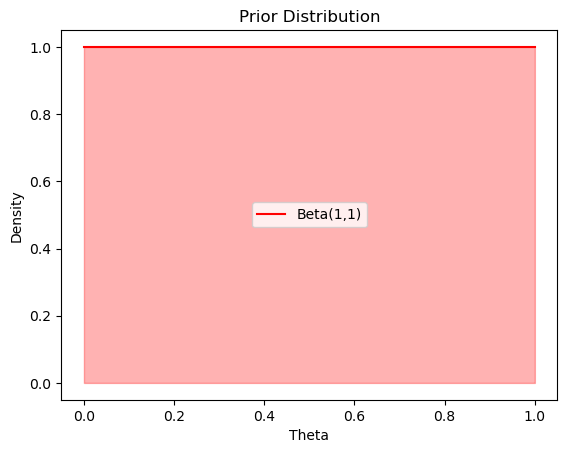

In [6]:
theta_grid = np.linspace(0, 1, 1000) # Create a grid of theta values (possible positions of the red ball)
a0, b0 = 1, 1  # Beta prior parameters
prior_pdf = scipy.stats.beta.pdf(theta_grid, a=a0, b=b0)

plt.plot(theta_grid, prior_pdf, label="Beta(1,1)", color="red")
plt.fill_between(theta_grid, prior_pdf, alpha=0.3, color="red")
plt.title("Prior Distribution")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

### Likelihood
We can use the binomial likelihood function to calculate the likelihood of observing X given N and theta by considering each ball to the left of the red ball as a success and each ball to the right as a failure. The probability of any given ball falling either side of the red ball, theta, is then also the position of the ball. I.e. if the value was 0.5 then there would be a 50% porbability of a white ball being to it's left.


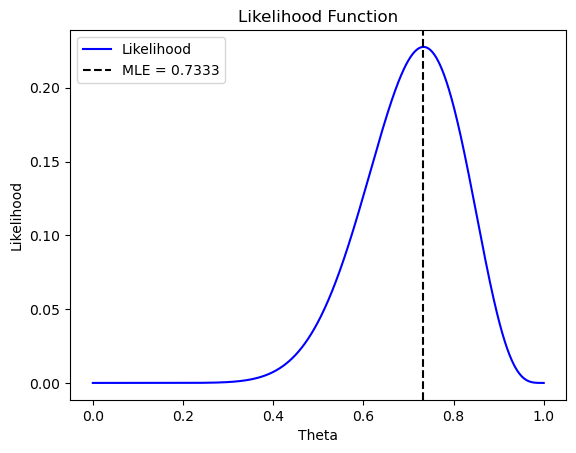

In [7]:
likelihood_values = scipy.stats.binom.pmf(X, N, theta_grid)

plt.plot(theta_grid, likelihood_values, label="Likelihood", color="blue")
plt.axvline(X / N, color="black", linestyle="--", label=f"MLE = {X / N:.4f}")
plt.title("Likelihood Function")
plt.xlabel("Theta")
plt.ylabel("Likelihood")
plt.legend()
plt.show()

### Analytical Solution

Here we caclulate the analytic solution as we saw in the slides, this works because we have a conjugate prior. The resulting posterior is also a beta distribution, with the parameters updated based on the observed data.

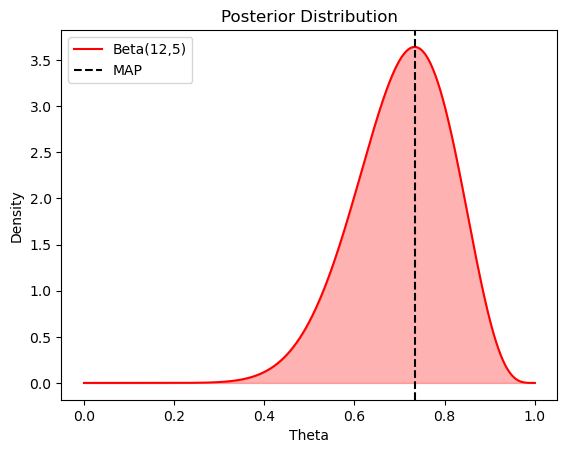

In [8]:
a_post = a0 + X
b_post = b0 + N - X
posterior_pdf = scipy.stats.beta.pdf(theta_grid, a_post, b_post)

plt.plot(theta_grid, posterior_pdf, label=f"Beta({a_post},{b_post})", color="red")
plt.fill_between(theta_grid, posterior_pdf, alpha=0.3, color="red")
plt.axvline((a_post - 1) / (a_post + b_post - 2), color="black", linestyle="--", label="MAP")
plt.title("Posterior Distribution")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

### Bayesian Inference with MCMC

Now we switch to PyMC, a Python library for probabilistic programming and Bayesian inference. This library allows us to define probabilistic models and perform inference using Markov Chain Monte Carlo (MCMC) methods.


#### 1. Model Specification in PyMC
To use PyMC we need to define a model. This means specifying a Likelihood function as well as a prior distribution for the parameters we want to estimate. In this case, we will use a Beta distribution as the prior for theta, and a Bernoulli distribution as the likelihood function as above.
In PyMC3 we specify the model using a context manager, defining the priors and likelihood within a `with` block.

In [9]:
billiard_model = pm.Model()
with billiard_model:
    # Define Prior
    theta = pm.Beta("theta", alpha=a0, beta=b0)
    # Define Likelihood
    x = pm.Bernoulli("x", p=theta, observed=np.concatenate([[1] * X, [0] * (N - X)]))

#### 2. Sampling from the Posterior

Now we can sample from the posterior distribution. The number of draws is an important parameter, as we want to make sure that convergence is reached, however more draws increases runtime and memory usage. You can check convergence diagnostics to ensure you have enough draws.

In [10]:
with billiard_model:
    posterior_sample = pm.sample(draws=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


#### 3. Visualizing MCMC Results

#### Interpreting a Trace Plot

A **trace plot** is a key diagnostic tool in Bayesian analysis to check whether an MCMC sampler has converged. It shows how the sampled values of a parameter change over iterations. We visualize the trace plot and extract summaries using ArviZ. 

*Characteristics of a Good Trace Plot*
- **Stationarity:** The chain fluctuates around a consistent mean and does not drift in one direction.
- **Good Mixing:** The samples move up and down rapidly without long periods of high or low values.
- **Low Autocorrelation:** The samples should appear random rather than highly correlated.

*Signs of Problems*
- **Drifting / Non-Stationarity:** If the chain trends in one direction, it has not converged yet. Consider increasing burn-in or adjusting the sampling parameters.
- **Poor Mixing:** If the values get "stuck" for many iterations before jumping, the sampler might not be exploring the posterior well.
- **Differences Between Chains:** If multiple chains do not overlap well, this indicates that the model might not have converged.

*Multiple Chains and Convergence Check*
- When running **multiple MCMC chains**, they should all look similar.
- The **R-hat statistic** should be close to 1.00 (values above 1.1 suggest convergence issues).

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

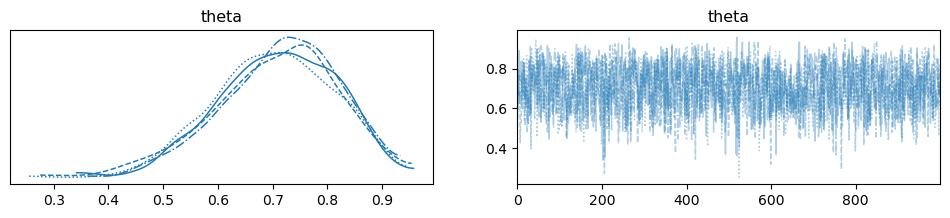

In [11]:
az.plot_trace(posterior_sample)

In [12]:
az.summary(posterior_sample, round_to=2, hdi_prob=0.90)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.71,0.11,0.52,0.87,0.0,0.0,1704.03,2230.88,1.0


We can also extract the samples to a numpy array

In [13]:
theta_samples = az.extract(
    posterior_sample, group="posterior", combined=False, var_names=["theta"]
).to_numpy()
# The array has dimension 4x1000, with the 4 chains and 1000 simulations per chain
print(theta_samples.shape)

(4, 1000)


#### 4. Plotting posterior distribution

Here we plot the posterior distribution of theta with the theoretical posterior from above.

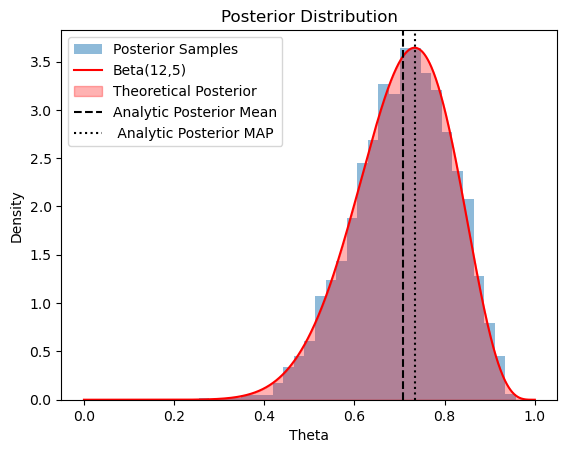

In [14]:
plt.hist(
    theta_samples.flatten(), bins=30, density=True, alpha=0.5, label="Posterior Samples"
)
plt.plot(
    theta_grid, posterior_pdf, label=f"Beta({a_post},{b_post})", color="red"
)
plt.fill_between(
    theta_grid, posterior_pdf, alpha=0.3, color="red", label="Theoretical Posterior"
)
plt.axvline(
    np.mean(theta_samples), color="black", linestyle="--", label="Analytic Posterior Mean"
)
plt.axvline(
    (a_post - 1) / (a_post + b_post - 2),color="black",linestyle=":",label=" Analytic Posterior MAP",
)
plt.title("Posterior Distribution")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

#### 5. Posterior Predictive Distribution

The posterior predictive distribution represents our uncertainty about future observations, given the data we have already seen and the inferred posterior distribution of the model parameters. Essentially, it tells us what future data might look like if we were to repeat the experiment.

Sampling: [x]


Output()

(4, 1000, 15)


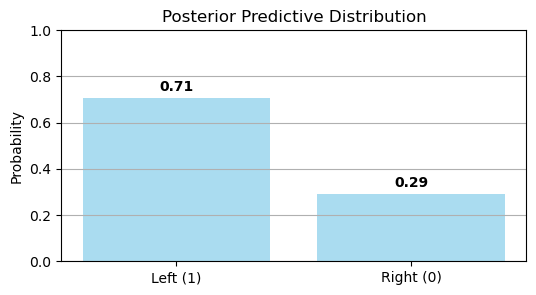

In [16]:
# here we simulate the posterior predictive distribution
with billiard_model:
    posterior_predictive = pm.sample_posterior_predictive(trace=posterior_sample, extend_inferencedata=True)

# Then we extract the posterior predictive samples
x_new_simulate = az.extract(
    posterior_sample, group="posterior_predictive", combined=False
)['x'].to_numpy()
# The array has dimension 4x10_000xN (4 chains, 1000 simulations per chain, N observations)
print(x_new_simulate.shape)

# Now we can visualize the posterior predictive distribution
p_posterior_pred = x_new_simulate.mean()
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(
    ["Left (1)", "Right (0)"],
    [p_posterior_pred, 1 - p_posterior_pred],
    color="skyblue",
    alpha=0.7,
)
ax.set_title("Posterior Predictive Distribution")
ax.set_ylabel("Probability")
ax.set_ylim(0, 1)
for i, v in enumerate([p_posterior_pred, 1 - p_posterior_pred]):
    ax.text(i, v + 0.03, f"{v:.2f}", ha="center", fontweight="bold")
ax.grid(True, axis="y")
plt.show()

# Linear Regression in Bayesian form

Now we are going to work through another simulated example, but this time for a linear regression problem.


First we generate the data again, this time with a linear model with true intercept 1 and slope 2.

In [15]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame({"x": x, "y": y})

We can plot the data:

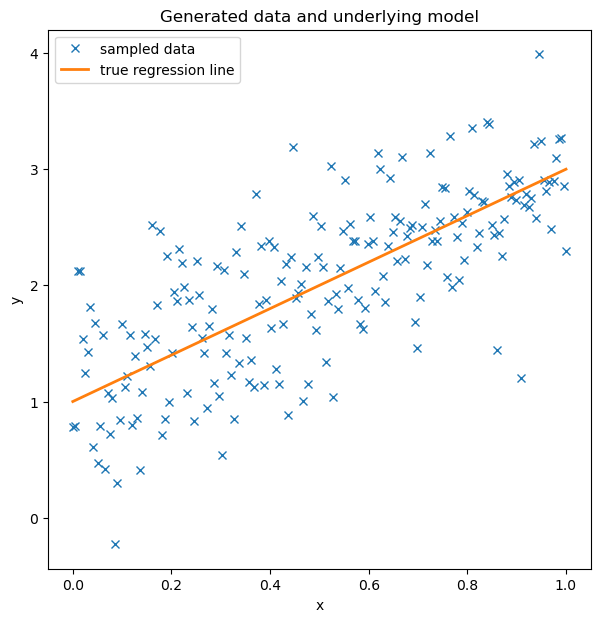

In [10]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

### PyMC

As we did we will have to define a model with a likelihood and prior distribution. However lets now consider our flat (uninformative) prior from above. Does this still make sense in this context? How would we bound it?

Instead we usually want to set a weakly informative prior, which incorporate engineering assumptions into the prior, as well as performing normalisation.

We could also set an informative prior, where we encode domain expertise into a probability distribution. This is the ideal type in Bayesian statistics, but in practice can be difficult as it is not always tractable to convert expertise into probability distributions nor is there always prior information available for all our parameters.

Below is the code for two of the most most common distributions used for priors, the Normal and student-t distribution. Play around with their parameters to get an intuition of how they work. (The Cauchy distribution, which is also common in cases where we want a distribution with thicker tales is just a special case of student t where degrees of freedom (`df`) is 1).

#### Normal and Student-T Distributions

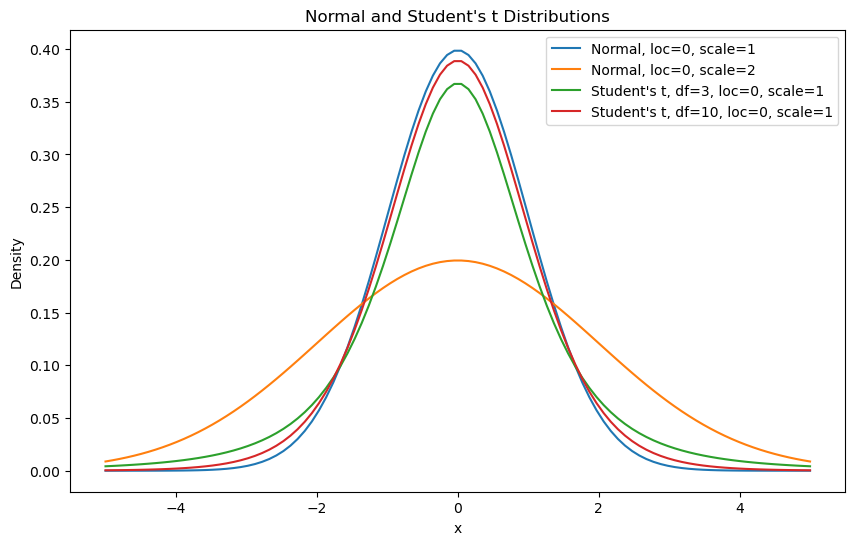

In [11]:
normal1_params = {"loc": 0, "scale": 1}
normal2_params = {"loc": 0, "scale": 2}
t1_params = {"df": 3, "loc": 0, "scale": 1}
t2_params = {"df": 10, "loc": 0, "scale": 1}

x = np.linspace(-5, 5, 100)
y_normal = scipy.stats.norm.pdf(x, **normal1_params)
y_normal_2 = scipy.stats.norm.pdf(x, **normal2_params)
y_t = scipy.stats.t.pdf(x, **t1_params)
y_t_2 = scipy.stats.t.pdf(x, **t2_params)
plt.figure(figsize=(10, 6))
plt.plot(x, y_normal, label=f"Normal, loc={normal1_params['loc']}, scale={normal1_params['scale']}")
plt.plot(x, y_normal_2, label=f"Normal, loc={normal2_params['loc']}, scale={normal2_params['scale']}")
plt.plot(x, y_t, label=f"Student's t, df={t1_params['df']}, loc={t1_params['loc']}, scale={t1_params['scale']}")
plt.plot(x, y_t_2, label=f"Student's t, df={t2_params['df']}, loc={t2_params['loc']}, scale={t2_params['scale']}")
plt.title("Normal and Student's t Distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

#### Defining our model

Now define our model as we did above, setting a prior for the intercept, slope and sigma.

Hint: As sigma cannot be negative, we must use 'Half' distributions, e.g. HalfNormal, HalfStudentT, HalfCauchy. These are the same as the other distributions but cut off at 0 so that they do not go negative.

In [16]:
linear_model = pm.Model()
with linear_model:
    # Define Priors
    slope = pm.StudentT("slope", nu=3, mu=0,sigma=1)
    intercept = pm.StudentT("intercept", nu=3, mu=0,sigma=1)
    sigma =  pm.HalfCauchy("sigma", beta=1) # errors
    # Define Likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

Now sample 3000 draws from the posterior distribution.

In [17]:
with linear_model:
    posterior_sample = sample(draws=3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 28 seconds.


Now use the summary and the trace plots to evaluate whether you have reached convergence.

array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

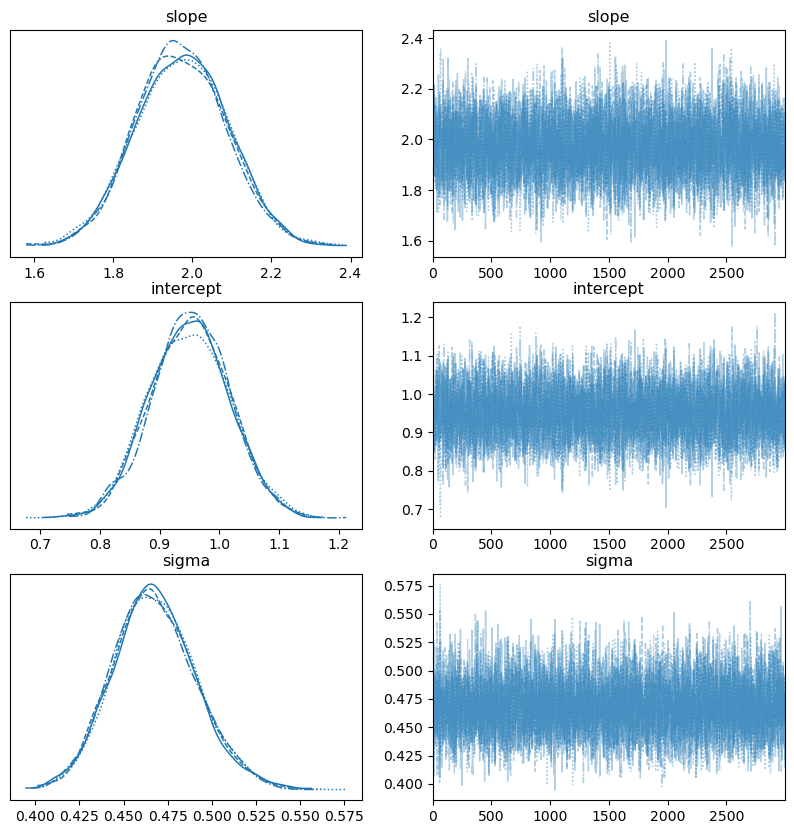

In [27]:
az.plot_trace(posterior_sample, figsize=(10, 10))

In [19]:
az.summary(posterior_sample, round_to=2, hdi_prob=0.90)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,1.97,0.11,1.79,2.16,0.0,0.0,5224.01,5483.16,1.0
intercept,0.95,0.07,0.84,1.06,0.0,0.0,5319.62,5333.11,1.0
sigma,0.47,0.02,0.43,0.51,0.0,0.0,6811.67,6549.68,1.0


And sample from the posterior predictive distribution, saving the samples as `posterior_predictive`.

In [28]:
# here we simulate the posterior predictive distribution
with linear_model:
    posterior_predictive = pm.sample_posterior_predictive(posterior_sample, extend_inferencedata=True)

Sampling: [y]


Output()

Finally, this code visualises our model. As our estimates are now probabilistic we have a range of best fitting regression lines, not just one. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. We can manually generate these regression lines using the posterior samples directly.

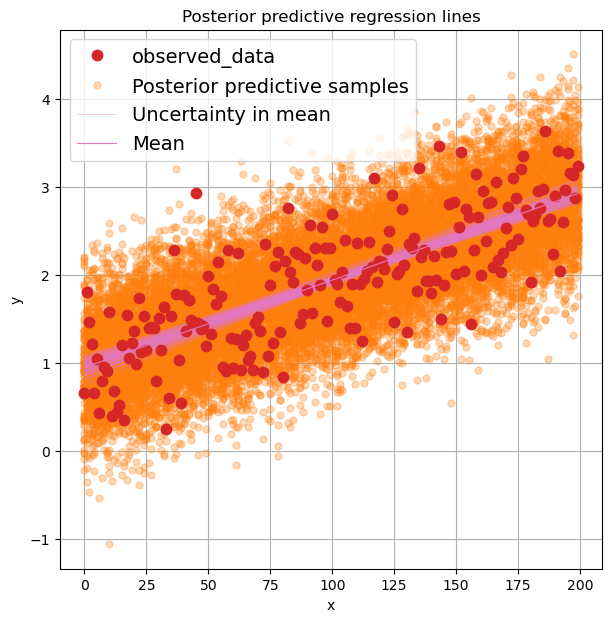

In [30]:
posterior_sample.posterior["y_model"] = posterior_sample.posterior["intercept"] + posterior_sample.posterior["slope"] * xr.DataArray(x)

_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=posterior_sample, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");

## Bonus:
Apply this Bayesian Framework for Regression to a real world Dataset we have considered.